# Point Cloud Demonstrations

## Registration

Registers two point clouds with slight offset.


In [1]:
import open3d as o3d
import numpy as np
import copy
import random
import copy
import scipy.spatial
import matplotlib.pyplot as plt
from collections import Counter

import utils
import correspondance as corr

In [ ]:
def draw_registration_result_original_color(source, target, transformation):
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target])

# load point clouds
base = o3d.io.read_point_cloud("./Point Clouds/Cleaner/1.ply")
source = o3d.io.read_point_cloud("./Point Clouds/Cleaner/8.ply")

# get 4x4 transformation matrix
trans = corr.register_clouds(base, source)

# show original clouds
o3d.visualization.draw_geometries([base, source])

# show aligned clouds
draw_registration_result_original_color(source, base, trans)


## Normals of point cloud
Shows the histogram of normals for the cloud. See utils module - running in notebook is much slower

## Outlier removal
Removes outliers and scatter artifacts from the pointcloud

In [ ]:
cl, ind=utils.clean_cloud("./Point Clouds/Cleaner/1.ply", view=True)

## Cleaned and combined 8 clouds

In [ ]:
base = o3d.io.read_point_cloud("./Point Clouds/combined_cloud_clean_cropped.ply")
o3d.visualization.draw_geometries([base])

# Region Growing Segmentation
Demonstrates region growing algorithm for downsampled cloud

In [ ]:
cl = o3d.io.read_point_cloud("./Point Clouds/combined_cloud_clean_cropped.ply")
pcd = cl.voxel_down_sample(0.01)

planes_list = corr.region_grow(pcd)

for plane in planes_list:
    colour = [random.uniform(0,1),random.uniform(0,1),random.uniform(0,1)]
    for i in plane:
        pcd.colors[i] = colour

o3d.visualization.draw_geometries([pcd])

# extract walls which is the largest object in the cloud

walls = planes_list[np.argmax(np.array([len(i) for i in planes_list]))]
walls = pcd.select_down_sample(walls)

## Isolating each wall plane

In [ ]:
planes_list, plane_normals = corr.region_grow(walls, 0.8, True)

colours = [[1,0,0],[0,1,0],[0,0,1]]

for plane, colour in zip(planes_list, colours):
    for i in plane:
        walls.colors[i] = colour

o3d.visualization.draw_geometries([walls])

print(plane_normals)


## SVD of Walls
Principle vectors pick out the normals of the wall

In [ ]:
plane = planes_list[1]
wall_cp = copy.deepcopy(walls)
plane = wall_cp.select_down_sample(plane)
points = np.asarray(plane.points)
points -= np.mean(points, axis=0)
u, s, v = np.linalg.svd(points)

normal = np.matmul(np.linalg.pinv(points), np.ones(points.shape[0]))
normal /= np.linalg.norm(normal)

o3d.visualization.draw_geometries([plane, utils.create_vector_graph(v), utils.create_vector_graph([normal])])

## Match to plane in full size cloud  (deprec)

In [ ]:
# now match to the original full size point cloud

cl.paint_uniform_color([0.5,0.5,0.5])
print(plane_normals)
for norm, colour in zip(plane_normals, colours):
    dot_match = np.abs(1-np.asarray(cl.points).dot(norm))
    for i in range(len(dot_match)):
        if dot_match[i] <0.04:
            cl.colors[i] = colour

# add normals for clearer viewing
if not cl.has_normals():
    cl.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.04 * 2, max_nn=30))
o3d.visualization.draw_geometries([cl])

## DBSCAN Methods (deprec)

In [ ]:
pcd = o3d.io.read_point_cloud("./Point Clouds/combined_cloud_clean_cropped.ply")
pcd = pcd.voxel_down_sample(0.005)

isolated= corr.remove_planes(pcd)

labels = np.array(isolated.cluster_dbscan(eps=0.01, min_points=40, print_progress=True))
colours = np.random.rand(labels.max()+1, 3)
for i in range(len(labels)):
    if labels[i] == -1:
        isolated.colors[i] = [0,0,0]
        continue
    isolated.colors[i] = colours[labels[i]]
outliers = np.where(labels == -1)[0]
isolated = isolated.select_down_sample(outliers, invert=True)

o3d.visualization.draw_geometries([isolated])


## Merging model clouds


In [ ]:
scale = 1

cl1 = o3d.io.read_point_cloud("./Point Clouds/Field Clouds/Commander/1.3.ply")
cl1 = corr.isolate_model(cl1)
plane1 = utils.create_origin_plane(100)
cl1 += plane1
cl1.scale(scale)

for i in range(4):
    print(i)
    cl2 = o3d.io.read_point_cloud("./Point Clouds/Field Clouds/Commander/1.{}.ply".format(i+2))
    cl2 = corr.isolate_model(cl2)
    temp_cl = cl2 + plane1
    
    temp_cl.scale(scale)
    cl2.scale(scale)
    print("Registering")
    tran = corr.register_clouds(cl1, temp_cl, voxel_radius=[0.01, 0.005, 0.0001], max_iter=[1000,1000,10000])
    
    cl2 = cl2.transform(tran)
    cl1 += cl2
    cl1.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.04 * 2, max_nn=30))
    
o3d.visualization.draw_geometries([cl1])

# Reference models

In [ ]:
cmdr = o3d.io.read_point_cloud("./Point Clouds/Commander Ref.ply")
brdsd = o3d.io.read_point_cloud("./Point Clouds/Broadside Ref.ply")
o3d.visualization.draw_geometries([cmdr])
o3d.visualization.draw_geometries([brdsd])

# Recognising Models

In [ ]:
isolated = o3d.io.read_point_cloud("isolated.ply")
o3d.visualization.draw_geometries([isolated])

labels = np.array(isolated.cluster_dbscan(eps=0.01, min_points=40, print_progress=True))
targets = []
print(Counter(labels))
for i in range(labels.max()+1):
    obj = np.where(labels==i)[0]
    obj = isolated.select_down_sample(obj)
    obj = obj.translate(-obj.get_center())
    targets.append(obj)
    print(len(obj.points))
    print(obj.get_oriented_bounding_box().volume())

In [ ]:
# for i in targets:
#     print(i.get_oriented_bounding_box().volume())
cmdr = o3d.io.read_point_cloud("./Point Clouds/Commander Ref.ply")
brdsd = o3d.io.read_point_cloud("./Point Clouds/Broadside Ref.ply")

cmdr_vol = cmdr.get_oriented_bounding_box().volume()
brdsd_vol = brdsd.get_oriented_bounding_box().volume()
print("Ref volumes:")
print("Commander: {}".format(cmdr.get_oriented_bounding_box().volume()))
print("Broadside: {}".format(brdsd.get_oriented_bounding_box().volume()))
print(np.asarray(cmdr.get_oriented_bounding_box().get_box_points()))

# print("Commander matching")
# for pcd in targets:
#     vol = pcd.get_oriented_bounding_box().volume()
#     if vol > 0.3*cmdr_vol and vol < cmdr_vol:
#         o3d.visualization.draw_geometries([pcd])
        
# print("Broadside matching")
# for pcd in targets:
#     vol = pcd.get_oriented_bounding_box().volume()
#     if vol > 0.3*brdsd_vol and vol < brdsd_vol:
#         o3d.visualization.draw_geometries([pcd])

## Getting building axis

In [ ]:
# use this function in the table scenes, it will produce for the buildings the normal histograms

def matching(pcd, labels):
    # define fp to reference models
    refs = {}
    refs["Commander"] = o3d.io.read_point_cloud("./Point Clouds/Commander Ref.ply")
    refs["Broadside"] = o3d.io.read_point_cloud("./Point Clouds/Broadside Ref.ply")
    ref_vols = np.array([i.get_oriented_bounding_box().volume() for j, i in refs.items()])

    # go through all clusters that have been labelled but not classified as
    # outliers or the table plane
    for i in range(labels.max()):  # note that this will go up to but not include table
        cluster = np.where(labels == i)[0]
        cluster = pcd.select_down_sample(cluster)
        vol = cluster.get_oriented_bounding_box().volume()

        # first filter possible matches based on size
        matches = []
        if vol > np.max(ref_vols): # potentially item of scenery, cluster more finely
            print("Scenery cluster")
            cluster.estimate_normals()
            cluster.normalize_normals()
            planes, normals = corr.region_grow(cluster, find_planes=True)
            lens = np.array([len(i) for i in planes])
            normals = np.multiply(lens, normals.T).T
            vecs = utils.hist_normals(normals, bin_size=0.95)
            vecs = utils.create_vector_graph(vecs)
            vecs2 = utils.hist_normals(np.asarray(cluster.normals), bin_size=0.95)
            vecs2 = utils.create_vector_graph(vecs2)
            vecs2.paint_uniform_color([1,0,0])
            o3d.visualization.draw_geometries([cluster, vecs, vecs2, cluster.get_axis_aligned_bounding_box()])

                
clouds = []
for i in range(2,6):
    clouds.append(o3d.io.read_point_cloud("./Point Clouds/Field Clouds/Board 2/7.{}.ply".format(i)))

print("Segmenting")
pcd = clouds[0]
labels, norm = corr.segment(pcd)
inliers = np.where(labels != -1)[0]
pcd = pcd.select_down_sample(inliers)
labels = np.array([i for i in labels if i !=-1])
T = utils.align_vectors(norm, np.array([0, 1, 0]))
pcd = pcd.transform(T)
pcd.translate(-pcd.get_center())
dist = np.mean(np.asarray(pcd.points)[np.where(labels == labels.max())[0]], axis=0)
pcd.translate(np.array([0,-1,0])*dist[1])

matching(pcd,labels)

Scenery cluster
[0.46008882 0.44839531]
[0.03690796 0.22645072]


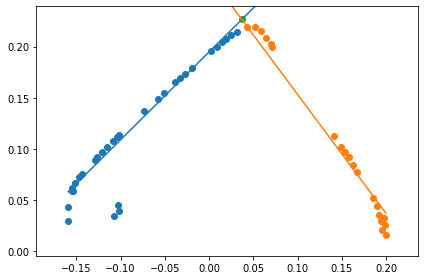

Scenery cluster
[-2.84205135  0.08200741]
[-0.04766075  0.04188941]


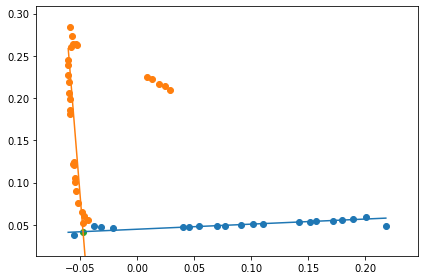

Scenery cluster
[3.78701657 7.43070234]
[-0.14913921  0.07675924]


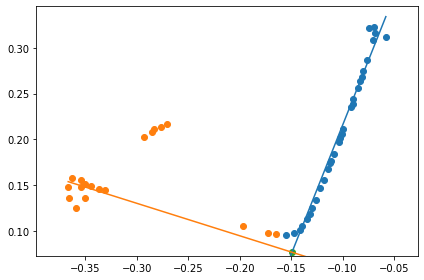

Scenery cluster
[-6.26391765  6.59981439]
[0.05232185 0.09255491]


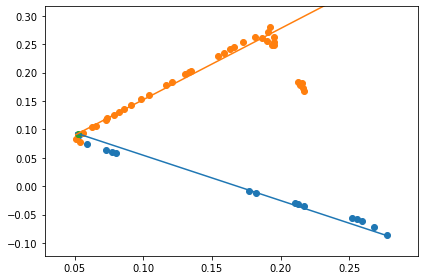

In [2]:
%matplotlib inline

def lines(x, n):
    return 1/n[1] - n[0]*x/n[1]

# This will plot the best fit lines for the corners
def matching2(pcd, labels):
    # define fp to reference models
    refs = {}
    refs["Commander"] = o3d.io.read_point_cloud("./Point Clouds/Commander Ref.ply")
    refs["Broadside"] = o3d.io.read_point_cloud("./Point Clouds/Broadside Ref.ply")
    ref_vols = np.array([i.get_oriented_bounding_box().volume() for j, i in refs.items()])

    # go through all clusters that have been labelled but not classified as
    # outliers or the table plane
    for i in range(labels.max()):  # note that this will go up to but not include table
        cluster = np.where(labels == i)[0]
        cluster = pcd.select_down_sample(cluster)
        vol = cluster.get_oriented_bounding_box().volume()

        # first filter possible matches based on size
        matches = []
        if vol > np.max(ref_vols): # potentially item of scenery, cluster more finely
            print("Scenery cluster")
            points = np.asarray(cluster.points)
            points = np.delete(points, 1, axis=1)
            points = np.concatenate((points, np.ones((points.shape[0], 1))), axis=1)
            hull = scipy.spatial.ConvexHull(points[:,:2])
            hull_pts = points[hull.vertices]
            while len(hull_pts) < 50:
                points = np.delete(points, hull.vertices, axis=0)
                hull = scipy.spatial.ConvexHull(points[:,:2])
                hull_pts =np.append(hull_pts, points[hull.vertices], axis=0)
                x = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(hull_pts)).voxel_down_sample(0.01)
                hull_pts = np.asarray(x.points)
            hull_pts = hull_pts[:,:2]

            R = np.array([[0, -1],
                          [1, 0]])
            n, alpha, ind1, ind2, cost = utils.fit_corner2(hull_pts)
            line_x = np.linspace(hull_pts[:, 0].min(), hull_pts[:, 0].max())
            y1 = lines(line_x, n)
            y2 = lines(line_x, R.dot(n)/alpha)
#             plt.scatter(points[:,0], points[:,1])
            for i in [ind1, ind2]:
                plt.scatter(hull_pts[i, 0], hull_pts[i,1])
            corner = np.sum(np.linalg.inv(np.array([n, R.dot(n)/alpha])), axis=1)
            print(corner)
            plt.scatter(corner[0], corner[1])
            plt.plot(line_x, y1)
            plt.plot(line_x, y2)
            xrange = hull_pts[:,0].max()-hull_pts[:,0].min()
            plt.xlim(hull_pts[:,0].min()-0.1*xrange, hull_pts[:,0].max()+0.1*xrange,)
            yrange = hull_pts[:,1].max()-hull_pts[:,1].min()
            plt.ylim(hull_pts[:,1].min()-0.1*yrange, hull_pts[:,1].max()+0.1*yrange,)
            plt.tight_layout()
            plt.show()


clouds = []
for i in range(2,6):
    clouds.append(o3d.io.read_point_cloud("./Point Clouds/Field Clouds/Board 2/7.{}.ply".format(i)))

# for i in range(1,8):
#     clouds.append(o3d.io.read_point_cloud("./Point Clouds/Field Clouds/Board 1/6.{}.ply".format(i)))

for pcd in clouds:
    labels, norm = corr.segment(pcd)
    R = utils.align_vectors(norm, np.array([0,1,0]))
    pcd.transform(R)
    pcd.translate(-pcd.get_center())
    table = np.where(labels == labels.max())
    points = np.asarray(pcd.points)
    table_pts = points[table]
    pcd.translate(np.array([0, -np.mean(table_pts, axis=1)[1], 0]))

    matching2(pcd, labels)


In [2]:
clouds = []
for i in range(2,6):
    clouds.append(o3d.io.read_point_cloud("./Point Clouds/Field Clouds/Board 2/7.{}.ply".format(i)))

build_ref = o3d.io.read_triangle_mesh("./Point Clouds/Building Ref.ply")
build_ref = build_ref.compute_triangle_normals()

# for i in range(1,8):
#     clouds.append(o3d.io.read_point_cloud("./Point Clouds/Field Clouds/Board 1/6.{}.ply".format(i)))
pcd = clouds[1]
labels, norm = corr.segment(pcd)
clouds[1] = corr.building_align(pcd, labels, norm)
base = clouds[1].select_down_sample(np.where(labels != -1)[0])

for i in [0,2, 3]:
    pcd = clouds[i]
    labels, norm = corr.segment(pcd)
    clouds[i] = corr.building_align(pcd, labels, norm)
    clouds[i] = pcd.select_down_sample(np.where(labels!=-1)[0])

o3d.visualization.draw_geometries(clouds)

for i in [2 ,3, 0]:
    T = corr.register_clouds(base, clouds[i])
    clouds[i].transform(T)
    base += clouds[i]

base.estimate_normals()
base = base.voxel_down_sample(0.003)
labels, norm = corr.segment(base)
# base = utils.colour_labels(base, labels)

for i in range(labels.max()):
    cluster = np.where(labels == i)[0]
    cluster = base.select_down_sample(cluster)
    points = np.asarray(cluster.points)
    points = np.delete(points, 1, axis=1)
    plt.scatter(points[:,0], points[:,1])

building = 0
max_vol = 0
for i in range(labels.max()):  # note that this will go up to but not include table
    cluster = np.where(labels == i)[0]
    cluster = base.select_down_sample(cluster)
    vol = cluster.get_oriented_bounding_box().volume()
    # building will be largest cluster
    if vol > max_vol:
        max_vol = vol
        building = cluster

base = corr.building_align(base, labels, norm)
print(np.cbrt(max_vol/ build_ref.get_oriented_bounding_box().volume()))
build_ref.scale(np.cbrt(max_vol/ build_ref.get_oriented_bounding_box().volume()), center=False)
o3d.visualization.draw_geometries([building, build_ref])
o3d.visualization.draw_geometries([base.select_down_sample(np.where(labels != -1)[0])])

AttributeError: 'numpy.float64' object has no attribute 'dot'